Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
!git clone https://github.com/google-research/google-research.git

In [6]:
import sys
import os
import tarfile
import urllib
import zipfile
sys.path.append('/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite')

# Examples of streaming and non streaming inference with TF/TFlite

## Imports

In [7]:
# TF streaming
from kws_streaming.models import models
from kws_streaming.models import utils
from kws_streaming.models import model_utils
from kws_streaming.layers.modes import Modes


In [8]:
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf1
import logging
from kws_streaming.models import model_flags
from kws_streaming.models import model_params
from kws_streaming.train import inference
from kws_streaming.train import test
from kws_streaming.data import input_data
from kws_streaming.data import input_data_utils as du
tf1.disable_eager_execution()

In [9]:
config = tf1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)

In [10]:
# general imports
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal

In [11]:
tf.__version__

'2.13.1'

In [12]:
tf1.reset_default_graph()
sess = tf1.Session()
tf1.keras.backend.set_session(sess)
tf1.keras.backend.set_learning_phase(0)

/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/.venv/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


## Load wav file

In [13]:
def waveread_as_pcm16(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  samplerate, wave_data = wav.read(filename)
  # Read in wav file.
  return wave_data, samplerate

def wavread_as_float(filename, target_sample_rate=16000):
  """Read in audio data from a wav file.  Return d, sr."""
  wave_data, samplerate = waveread_as_pcm16(filename)
  desired_length = int(
      round(float(len(wave_data)) / samplerate * target_sample_rate))
  wave_data = scipy.signal.resample(wave_data, desired_length)

  # Normalize short ints to floats in range [-1..1).
  data = np.array(wave_data, np.float32) / 32768.0
  return data, target_sample_rate

In [29]:
# set PATH to data sets (for example to speech commands V2):
# it can be downloaded from
# https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
# if you run 00_check-data.ipynb then data2 should be located in the current folder
current_dir = os.getcwd()
DATA_PATH = os.path.join('/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/data_training')

In [30]:
# Set path to wav file for testing.
wav_file = os.path.join(DATA_PATH, "testing/wakeword/2.wav")

# read audio file
wav_data, samplerate = wavread_as_float(wav_file)

In [18]:
assert samplerate == 16000

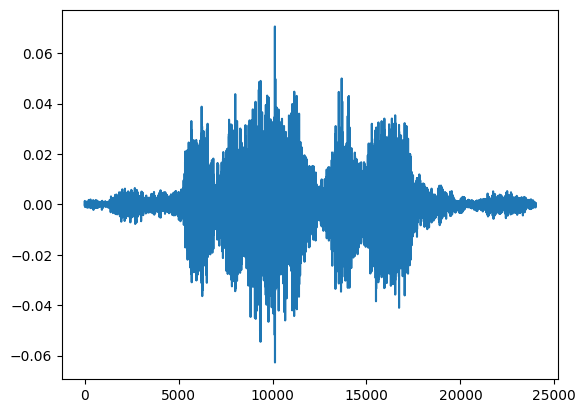

In [19]:
plt.plot(wav_data)

## Prepare batched model

In [31]:
# This notebook is configured to work with 'ds_tc_resnet' and 'svdf'.
MODEL_NAME = 'ds_cnn_16_hq'
# MODEL_NAME = 'svdf'
MODELS_PATH = os.path.join('/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/models1')
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME + "/")

In [32]:
train_dir = os.path.join(MODELS_PATH, MODEL_NAME)

In [33]:
# below is another way of reading flags - through json
with tf.compat.v1.gfile.Open(os.path.join(train_dir, 'flags.json'), 'r') as fd:
  flags_json = json.load(fd)

class DictStruct(object):
  def __init__(self, **entries):
    self.__dict__.update(entries)

flags = DictStruct(**flags_json)

In [34]:
flags.data_dir = DATA_PATH

In [35]:
# get total stride of the model

total_stride = 1
if MODEL_NAME == 'ds_tc_resnet':
  # it can be automated by scanning layers of the model, but for now just use parameters of specific model
  pools = model_utils.parse(flags.ds_pool)
  strides = model_utils.parse(flags.ds_stride)
  time_stride = [1]
  for pool in pools:
    if pool > 1:
      time_stride.append(pool)
  for stride in strides:
    if stride > 1:
      time_stride.append(stride)
  total_stride = np.prod(time_stride)

# overide input data shape for streaming model with stride/pool
flags.data_stride = total_stride
flags.data_shape = (total_stride * flags.window_stride_samples,)

In [36]:
# prepare mapping of index to word
audio_processor = input_data.AudioProcessor(flags)
index_to_label = {}
# labels used for training
for word in audio_processor.word_to_index.keys():
  if audio_processor.word_to_index[word] == du.SILENCE_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = du.SILENCE_LABEL
  elif audio_processor.word_to_index[word] == du.UNKNOWN_WORD_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = du.UNKNOWN_WORD_LABEL
  else:
    index_to_label[audio_processor.word_to_index[word]] = word

# training labels
index_to_label

2023-12-01 10:04:01.199684: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


{1: '_unknown_', 0: '_silence_'}

In [41]:
# pad input audio with zeros, so that audio len = flags.desired_samples
padded_wav = np.pad(wav_data, (0, 32000-len(wav_data)), 'constant')

input_data = np.expand_dims(padded_wav, 0)
input_data.shape
micro_processed = audio_processor.get_features_for_wav(wav_file, flags, sess)
flattened_data = np.array(micro_processed, dtype=np.float32).reshape(1,99, 40)
print(flattened_data)

[[[20.507812  18.789062  21.210938  ... 17.03125   15.9375    15.078125 ]
  [18.828125  19.296875  20.78125   ... 14.1015625 14.8046875 13.7109375]
  [18.945312  19.101562  19.726562  ... 10.078125  12.1484375  9.21875  ]
  ...
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]]


In [42]:
# create model with flag's parameters
model_non_stream_batch = models.MODELS[flags.model_name](flags)

# load model's weights
weights_name = 'best_weights'
model_non_stream_batch.load_weights(os.path.join(train_dir, weights_name))

2023-12-01 10:05:19.854457: W tensorflow/c/c_api.cc:304] Operation '{name:'conv2d_6/kernel/Assign' id:1328 op device:{requested: '', assigned: ''} def:{{{node conv2d_6/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_6/kernel, conv2d_6/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


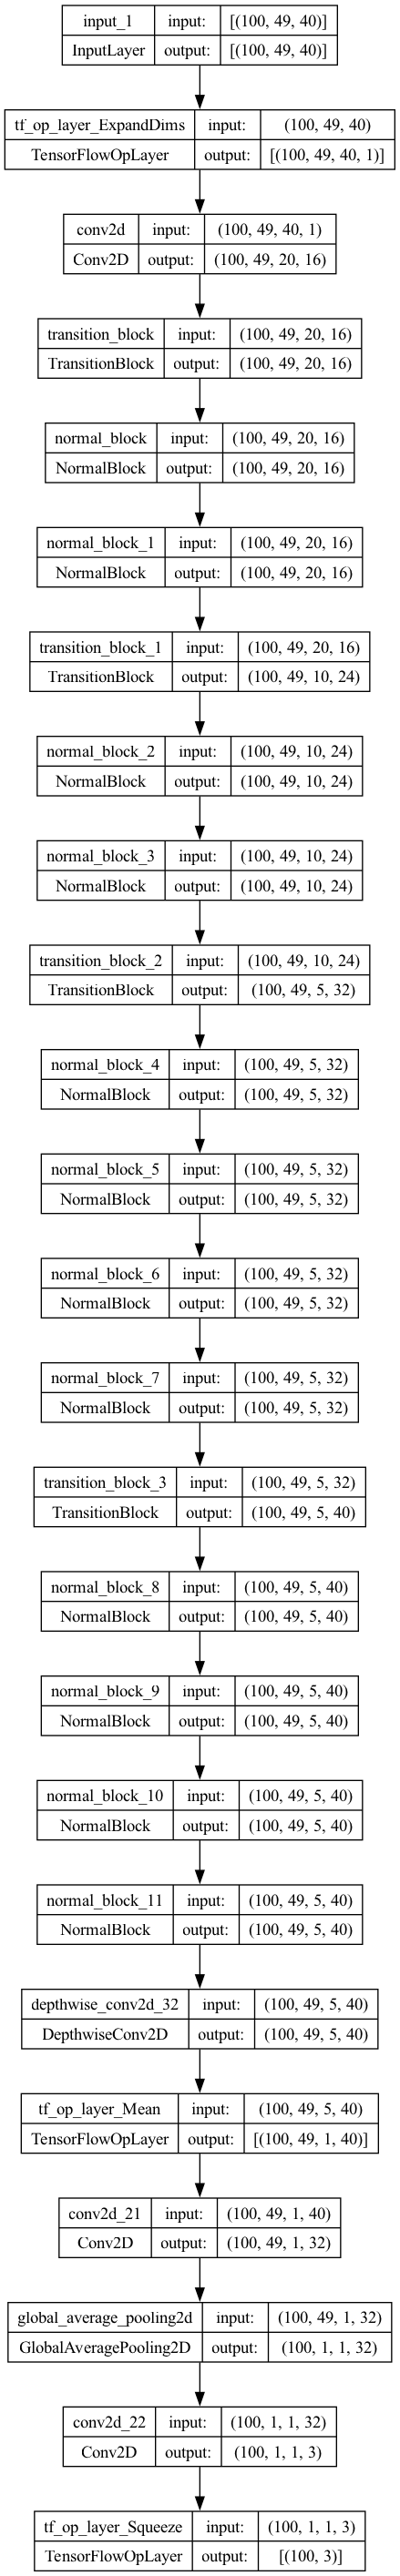

In [35]:
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

## Run inference with TF

### TF Run non streaming inference

In [63]:
# convert model to inference mode with batch one
inference_batch_size = 1
tf.keras.backend.set_learning_phase(0)
flags.batch_size = inference_batch_size  # set batch size

model_non_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.NON_STREAM_INFERENCE)
#model_non_stream.summary()

2023-12-01 10:22:46.655953: W tensorflow/c/c_api.cc:304] Operation '{name:'streaming_8/batch_normalization_9/moving_mean/Assign' id:4906 op device:{requested: '', assigned: ''} def:{{{node streaming_8/batch_normalization_9/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](streaming_8/batch_normalization_9/moving_mean, streaming_8/batch_normalization_9/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


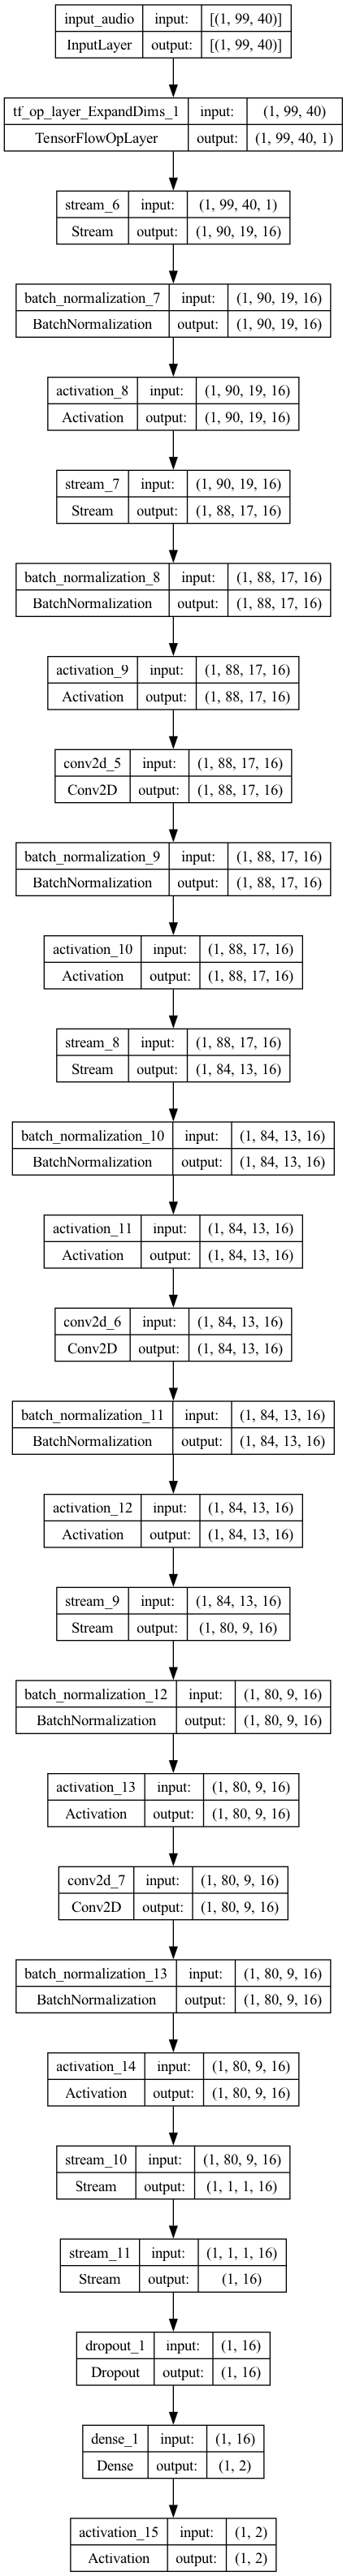

In [64]:
tf.keras.utils.plot_model(
    model_non_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [65]:
predictions = model_non_stream.predict(flattened_data)
print(predictions)
# predictions = model_non_stream.predict(input_data)
predicted_labels = np.argmax(predictions, axis=1)

[[0.9988778  0.00112223]]


/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-12-01 10:23:05.183094: W tensorflow/c/c_api.cc:304] Operation '{name:'streaming_8/activation_15/Softmax' id:5108 op device:{requested: '', assigned: ''} def:{{{node streaming_8/activation_15/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](streaming_8/dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [66]:
predicted_labels

array([0])

In [25]:
index_to_label[predicted_labels[0]]

'wakeword'

### TF Run streaming inference with internal state

In [67]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_INTERNAL_STATE_INFERENCE)
model_stream.summary()

/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/.venv/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
2023-12-01 10:23:18.906347: W tensorflow/c/c_api.cc:304] Operation '{name:'streaming_9/batch_normalization_12/beta/Assign' id:5486 op device:{requested: '', assigned: ''} def:{{{node streaming_9/batch_normalization_12/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](streaming_9/batch_normalization_12/beta, streaming_9/batch_normalization_12/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_audio (InputLayer)    [(1, 1, 40)]              0         
                                                                 
 tf_op_layer_ExpandDims_1 (  (1, 1, 40, 1)             0         
 TensorFlowOpLayer)                                              
                                                                 
 stream_6 (Stream)           (1, 1, 19, 16)            1056      
                                                                 
 batch_normalization_7 (Bat  (1, 1, 19, 16)            48        
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (1, 1, 19, 16)            0         
                                                                 
 stream_7 (Stream)           (1, 1, 17, 16)            1072

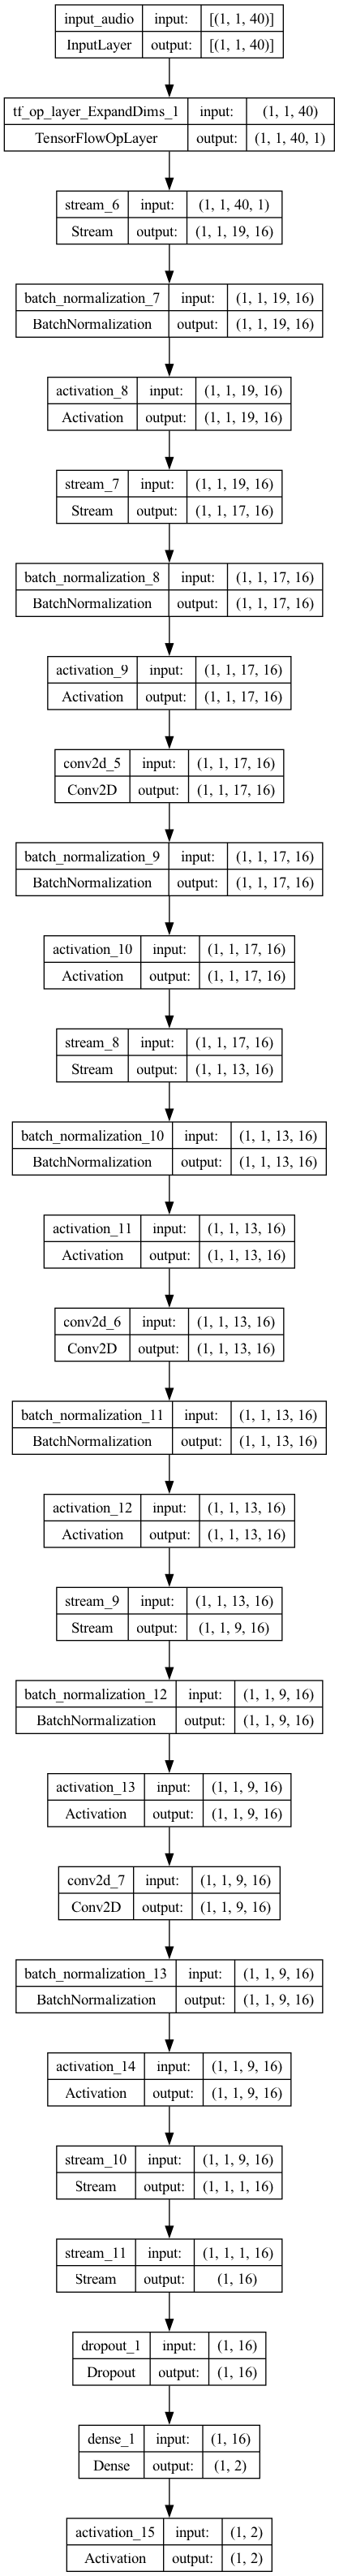

In [68]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [73]:
# truly_flattened = flattened_data.reshape(99*40)
stream_output_prediction = inference.run_stream_inference_classification(flags, model_stream, flattened_data)
# stream_output_prediction = inference.run_stream_inference_classification(flags, model_stream, input_data)
print(stream_output_prediction)

[]


In [32]:
stream_output_arg = np.argmax(stream_output_prediction)

ValueError: attempt to get argmax of an empty sequence

In [28]:
index_to_label[stream_output_arg]

'_silence_'

### TF Run streaming inference with external state

In [78]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream_external = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
model_stream.summary()

/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/.venv/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
2023-12-01 10:27:50.887221: W tensorflow/c/c_api.cc:304] Operation '{name:'streaming_11/batch_normalization_8/moving_mean/Assign' id:6269 op device:{requested: '', assigned: ''} def:{{{node streaming_11/batch_normalization_8/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](streaming_11/batch_normalization_8/moving_mean, streaming_11/batch_normalization_8/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_audio (InputLayer)    [(1, 1, 40)]              0         
                                                                 
 tf_op_layer_ExpandDims_1 (  (1, 1, 40, 1)             0         
 TensorFlowOpLayer)                                              
                                                                 
 stream_6 (Stream)           (1, 1, 19, 16)            1056      
                                                                 
 batch_normalization_7 (Bat  (1, 1, 19, 16)            48        
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (1, 1, 19, 16)            0         
                                                                 
 stream_7 (Stream)           (1, 1, 17, 16)            1072

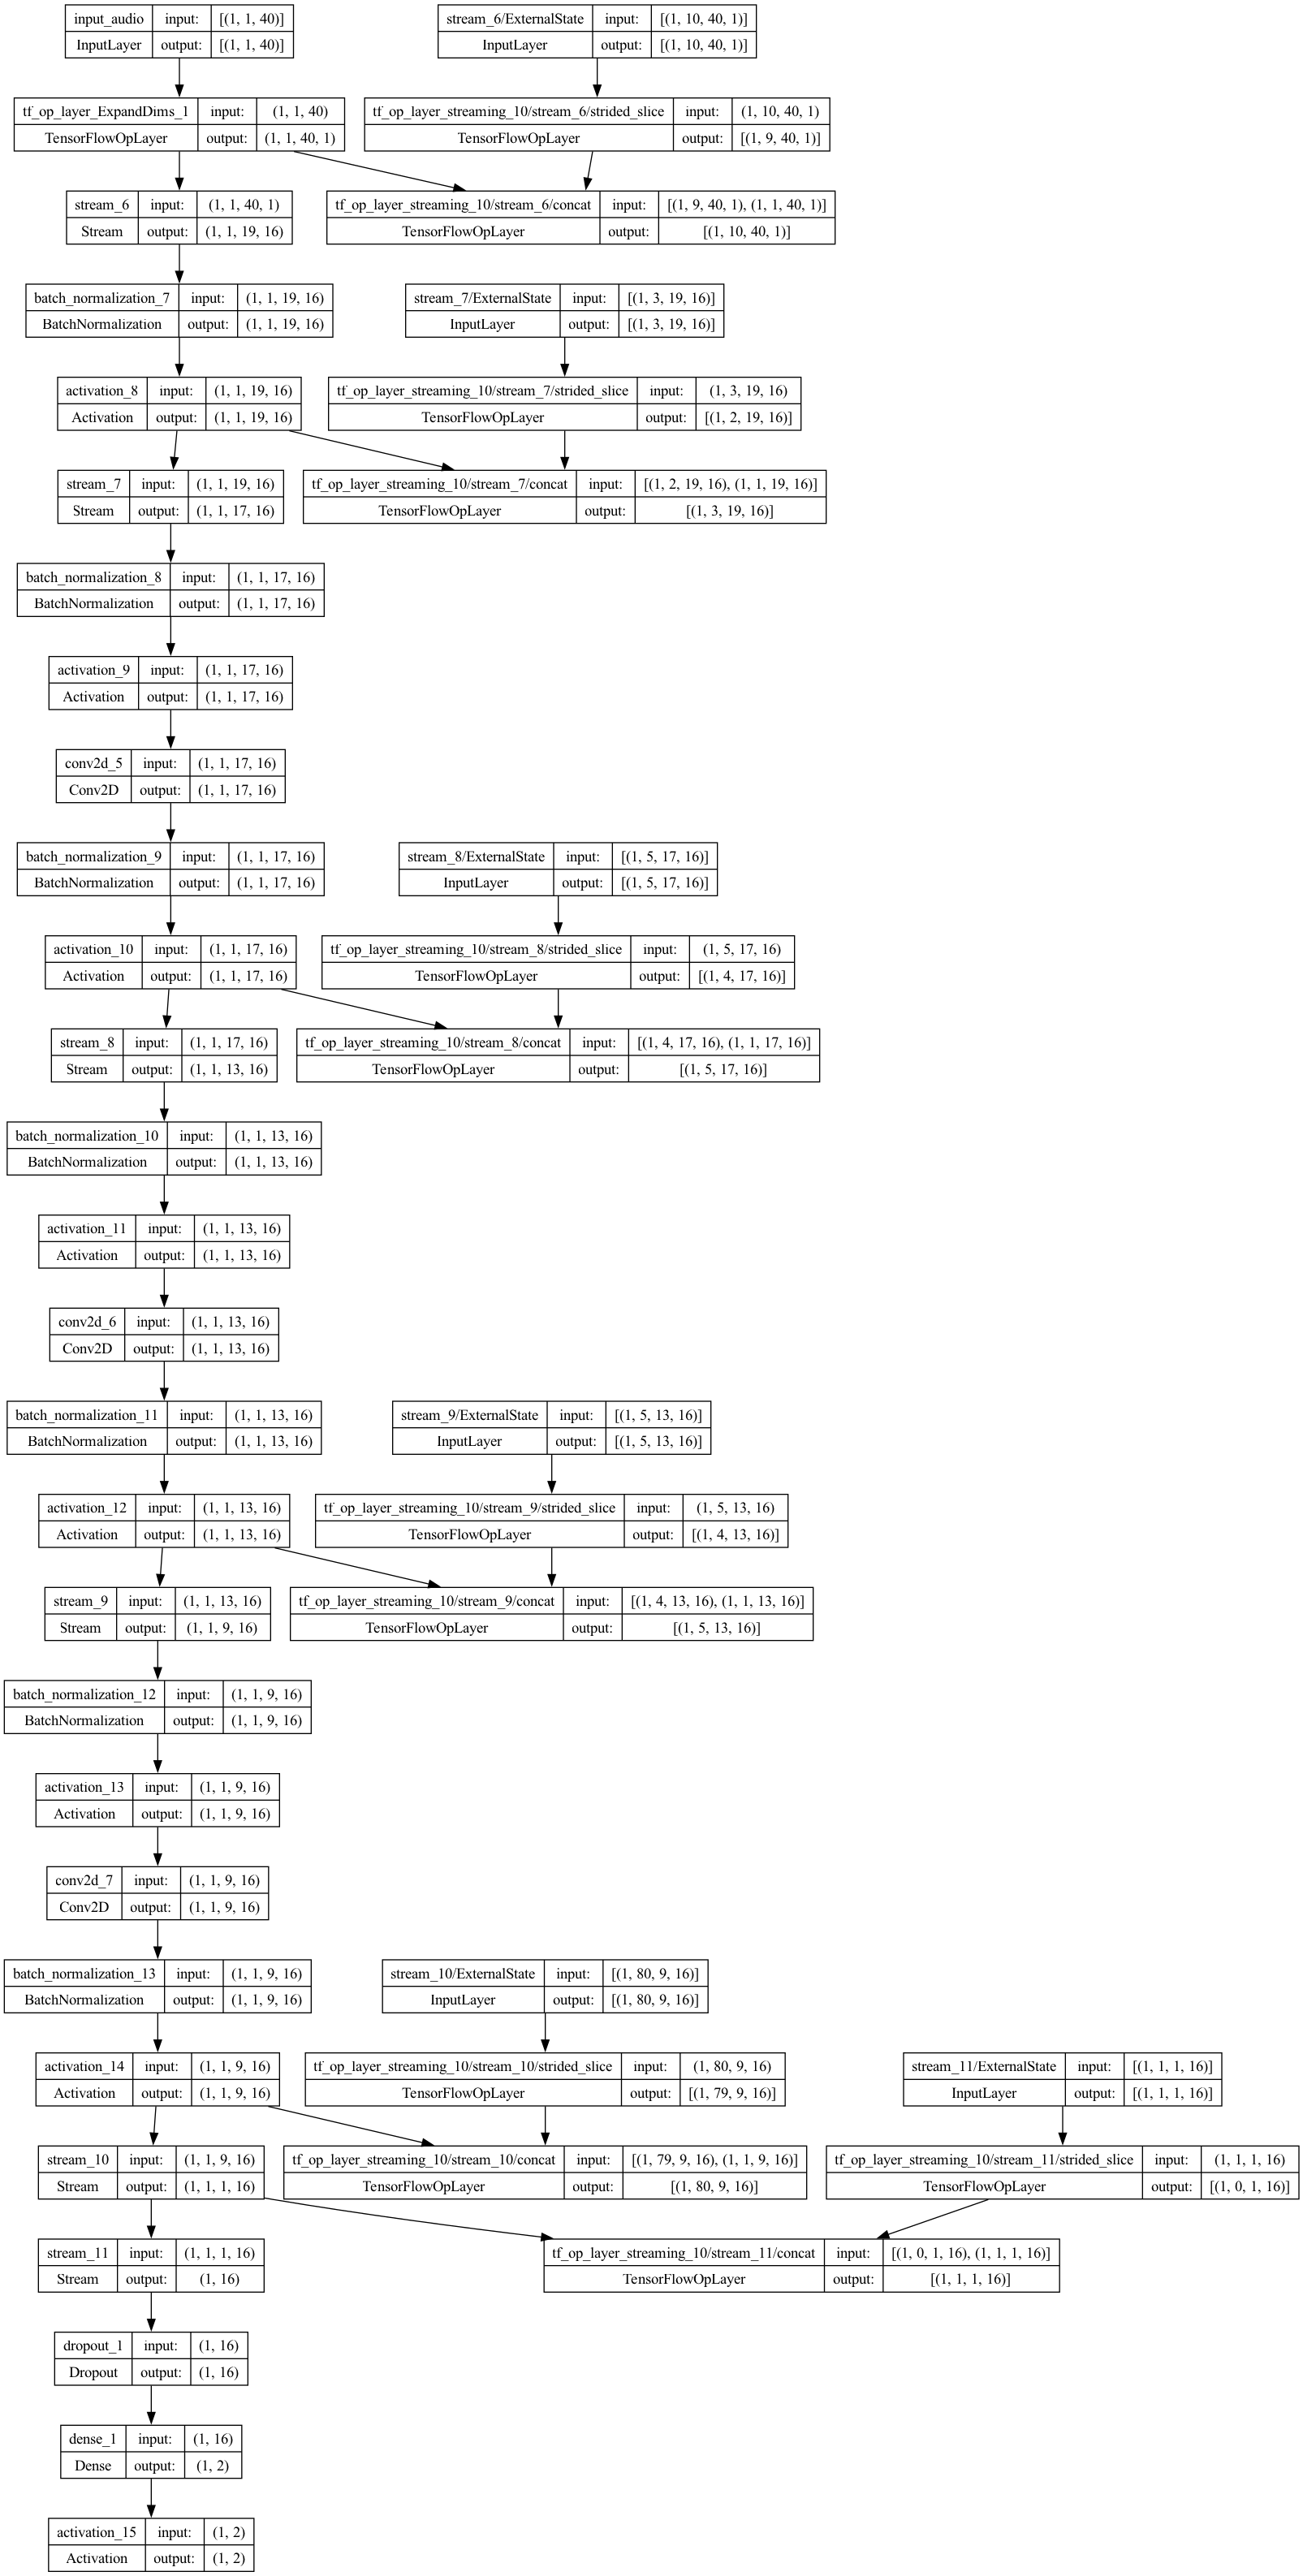

In [75]:
tf.keras.utils.plot_model(
    model_stream_external,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [89]:
inputs = []
# print(model_stream_external.inputs)
for s in range(len(model_stream_external.inputs)):
  inputs.append(np.zeros(model_stream_external.inputs[s].shape, dtype=np.float32))
# inputs = np.expand_dims(inputs, axis=0)

window_stride = 1 # flags.data_shape[0]

start = 0
end = window_stride
# flattened_data = flattened_data.reshape(40,49)
cut_down_data = flattened_data.reshape(99,40)
while end <= cut_down_data.shape[0]:
  # get new frame from stream of data
  stream_update = cut_down_data[start:end,:]
  # stream_update = input_data[:, start:end]
  # stream_update = stream_update.reshape(40)

  # update indexes of streamed updates
  start = end
  end = start + window_stride

  # set input audio data (by default input data at index 0)
  inputs[0] = stream_update.reshape(1,1,40)
  

  # run inference
  outputs = model_stream_external.predict(inputs)
  # outputs = model_stream_external.predict(inputs[0].reshape(1,1,40))

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(model_stream_external.inputs)):
    inputs[s] = outputs[s]


print(outputs[0])
#   stream_output_arg = np.argmax(outputs[0])
# stream_output_arg

[[0.9988778  0.00112223]]


In [77]:
index_to_label[stream_output_arg]

'_silence_'

## Run inference with TFlite

### Run non streaming inference with TFLite

In [55]:
tflite_non_streaming_model = utils.model_to_tflite(sess, model_non_stream_batch, flags, Modes.NON_STREAM_INFERENCE)
tflite_non_stream_fname = 'tflite_non_stream.tflite'
with open(os.path.join(MODEL_PATH, tflite_non_stream_fname), 'wb') as fd:
  fd.write(tflite_non_streaming_model)

2023-12-01 10:07:45.847029: W tensorflow/c/c_api.cc:304] Operation '{name:'streaming_6/batch_normalization_13/moving_variance/Assign' id:4195 op device:{requested: '', assigned: ''} def:{{{node streaming_6/batch_normalization_13/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](streaming_6/batch_normalization_13/moving_variance, streaming_6/batch_normalization_13/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-01 10:07:46.007735: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-12-01 10:07:46.008843: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
2023-12-01 10:07:46.145260: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-12-01 10:07:46.145346: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-12-01 10:07:46.146280: E tensorflow/core/grappler/grappler_item_builder.cc:670] Init node stream/kernel/Assign doesn't exist in graph
2023-12-01 10:07:46.174808: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-12-01 10:07:46.174825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-12-01 10:07:46.238099: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2138] Estimated count of arithmeti

In [56]:
interpreter = tf.lite.Interpreter(model_content=tflite_non_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [57]:
# set input audio data (by default input data at index 0)
interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))

# run inference
interpreter.invoke()

# get output: classification
out_tflite = interpreter.get_tensor(output_details[0]['index'])

out_tflite_argmax = np.argmax(out_tflite)

out_tflite_argmax

ValueError: Cannot set tensor: Dimension mismatch. Got 2 but expected 3 for input 0.

In [38]:
index_to_label[out_tflite_argmax]

'computer'

### Run streaming inference with TFLite

In [90]:
tflite_streaming_model = utils.model_to_tflite(sess, model_non_stream_batch, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
tflite_stream_fname = 'tflite_stream.tflite'

/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/.venv/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
2023-12-01 10:32:58.897236: W tensorflow/c/c_api.cc:304] Operation '{name:'streaming_12/batch_normalization_11/moving_variance/Assign' id:6879 op device:{requested: '', assigned: ''} def:{{{node streaming_12/batch_normalization_11/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](streaming_12/batch_normalization_11/moving_variance, streaming_12/batch_normalization_11/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't 

In [91]:
with open(os.path.join(MODEL_PATH, tflite_stream_fname), 'wb') as fd:
  fd.write(tflite_streaming_model)

In [92]:
interpreter = tf.lite.Interpreter(model_content=tflite_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_states = []
for s in range(len(input_details)):
  input_states.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [95]:
out_tflite = inference.run_stream_inference_classification_tflite(flags, interpreter, flattened_data, input_states)

UnboundLocalError: local variable 'out_tflite' referenced before assignment

In [43]:
out_tflite_argmax = np.argmax(out_tflite[0])

In [44]:
index_to_label[out_tflite_argmax]

'_silence_'

## Run evaluation on all testing data

In [47]:
test.tflite_non_stream_model_accuracy(
    flags,
    MODEL_PATH,
    tflite_model_name=tflite_non_stream_fname,
    accuracy_name='tflite_non_stream_model_accuracy.txt')

84.24479166666666

In [46]:
test.tflite_stream_state_external_model_accuracy(
    flags,
    MODEL_PATH,
    tflite_model_name=tflite_stream_fname,
    accuracy_name='tflite_stream_state_external_model_accuracy.txt',
    reset_state=True)

12.5

In [45]:
test.tflite_stream_state_external_model_accuracy(
    flags,
    MODEL_PATH,
    tflite_model_name=tflite_stream_fname,
    accuracy_name='tflite_stream_state_external_model_accuracy.txt',
    reset_state=False)

12.5